# Flight Delay Prediction System

## Objective
Predict whether a flight will be delayed (arrival delay ≥ 15 minutes) <br>
using historical flight schedule and delay data. <br>

## Steps:
1. Data Collection <br>
2. Time-Based Exploratory Data Analysis <br>
3. Feature Engineering <br>
4. Model Training <br>
5. Delay Factor Analysis <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## 1. Data Collection

The dataset used in this project contains historical flight information including departure time, arrival delay, airline, airport, and weather-related delay details.

To ensure computational efficiency, a random sample of 200,000 rows was selected from the full dataset.

Cancelled and diverted flights were removed to ensure meaningful delay analysis.

In [2]:
flights = pd.read_csv("flights.csv", low_memory=False)
flights = flights.sample(200000, random_state=42)
flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 1508570 to 136977
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 200000 non-null  int64  
 1   MONTH                200000 non-null  int64  
 2   DAY                  200000 non-null  int64  
 3   DAY_OF_WEEK          200000 non-null  int64  
 4   AIRLINE              200000 non-null  object 
 5   FLIGHT_NUMBER        200000 non-null  int64  
 6   TAIL_NUMBER          199521 non-null  object 
 7   ORIGIN_AIRPORT       200000 non-null  object 
 8   DESTINATION_AIRPORT  200000 non-null  object 
 9   SCHEDULED_DEPARTURE  200000 non-null  int64  
 10  DEPARTURE_TIME       197128 non-null  float64
 11  DEPARTURE_DELAY      197128 non-null  float64
 12  TAXI_OUT             197029 non-null  float64
 13  WHEELS_OFF           197029 non-null  float64
 14  SCHEDULED_TIME       200000 non-null  float64
 15  ELAPSED_TIME    

In [3]:
flights = flights.reset_index(drop=True)

In [4]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,4,7,2,EV,4900,N759EV,FWA,DTW,1340,...,1423.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,24,6,AS,611,N413AS,LAS,SEA,1910,...,2133.0,-12.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,7,8,3,WN,1483,N463WN,OAK,SEA,630,...,812.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,5,26,2,WN,193,N7745A,STL,DAL,810,...,1222.0,152.0,0,0,NaN,0.0,0.0,0.0,152.0,0.0
4,2015,7,6,1,UA,253,N213UA,IAH,HNL,1000,...,1316.0,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Cleaning

Data preprocessing steps included:

- Removing cancelled and diverted flights.
- Dropping rows with missing arrival delay values.
- Creating a binary target variable:
    - 1 = Delayed (arrival delay ≥ 15 minutes)
    - 0 = Not delayed

In [5]:

# Keep only flights that actually flew normally
flights = flights[(flights["CANCELLED"] == 0) & (flights["DIVERTED"] == 0)]

# Remove rows where arrival delay is missing (can't label them)
flights = flights.dropna(subset=["ARRIVAL_DELAY"]).reset_index(drop=True)

flights.shape

(196510, 31)

In [6]:
flights["DELAYED"]= (flights["ARRIVAL_DELAY"] >= 15).astype(int)

In [7]:
flights["DELAYED"].value_counts()

DELAYED
0    159897
1     36613
Name: count, dtype: int64

In [8]:
flights.tail()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAYED
196505,2015,1,19,1,UA,328,N772UA,DEN,HNL,1130,...,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
196506,2015,6,14,7,EV,4687,N13978,BNA,EWR,846,...,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
196507,2015,9,30,3,DL,1370,N950DN,ROC,ATL,1159,...,68.0,0,0,NaN,0.0,0.0,3.0,65.0,0.0,1
196508,2015,4,22,3,EV,6099,N27200,DEN,SHV,1005,...,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
196509,2015,1,9,5,AA,1399,N456AA,STL,DFW,1627,...,-17.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0


## 3. Time-Based Exploratory Data Analysis

To understand patterns in flight delays, time-based analysis was performed across:

- Monthly trends
- Day-of-week patterns
- Hour-of-day departure impact

This analysis helps identify seasonal and operational congestion effects influencing delays.

In [9]:
# Calculate delay rate by month
monthly_delay = flights.groupby("MONTH")["DELAYED"].mean()

monthly_delay

MONTH
1     0.208842
2     0.229369
3     0.194065
4     0.173676
5     0.178213
6     0.237034
7     0.214524
8     0.184424
9     0.130016
10    0.128789
11    0.150273
12    0.208833
Name: DELAYED, dtype: float64

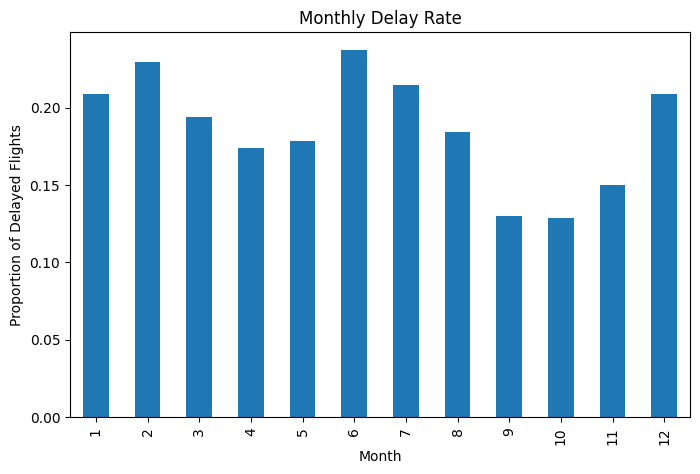

In [10]:
plt.figure(figsize=(8,5))
monthly_delay.plot(kind="bar")
plt.title("Monthly Delay Rate")
plt.ylabel("Proportion of Delayed Flights")
plt.xlabel("Month")
plt.show()

### Monthly Delay Analysis Insight

The delay rate peaks in June, likely due to increased summer travel and higher airport congestion. <br>
September shows the lowest delay rate, possibly due to reduced travel demand after peak summer months. <br>
This suggests seasonal patterns significantly influence flight delays.

In [11]:
# Calculate delay rate by day of week
weekday_delay = flights.groupby("DAY_OF_WEEK")["DELAYED"].mean()

weekday_delay

DAY_OF_WEEK
1    0.198041
2    0.186444
3    0.181843
4    0.200231
5    0.191545
6    0.161176
7    0.179554
Name: DELAYED, dtype: float64

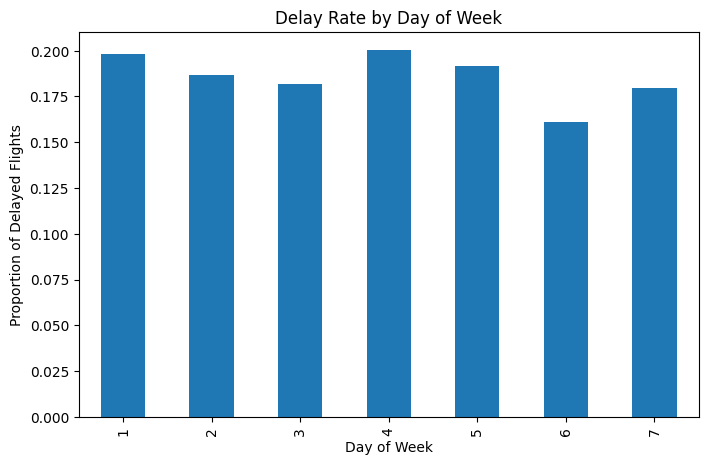

In [12]:
plt.figure(figsize=(8,5))
weekday_delay.plot(kind="bar")
plt.title("Delay Rate by Day of Week")
plt.ylabel("Proportion of Delayed Flights")
plt.xlabel("Day of Week")
plt.show()

### Day of Week Analysis Insight

Thursday shows the highest delay rate, possibly due to increased business travel and accumulated midweek congestion.<br>
Saturday has the lowest delay rate, likely because of reduced business travel demand and lower airport traffic.<br>
This suggests weekly travel patterns influence operational delays.

In [13]:
# Convert scheduled departure into hour
flights["DEP_HOUR"] = flights["SCHEDULED_DEPARTURE"] // 100

flights[["SCHEDULED_DEPARTURE", "DEP_HOUR"]].head()

,SCHEDULED_DEPARTURE,DEP_HOUR
0,1340,13
1,1910,19
2,630,6
3,810,8
4,1000,10


In [14]:
hourly_delay = flights.groupby("DEP_HOUR")["DELAYED"].mean()

hourly_delay

DEP_HOUR
0     0.168016
1     0.208589
2     0.205128
3     0.076923
4     0.214286
5     0.068888
6     0.091983
7     0.116341
8     0.125118
9     0.144715
10    0.156608
11    0.165707
12    0.179470
13    0.195361
14    0.209429
15    0.216277
16    0.227517
17    0.245851
18    0.259406
19    0.257628
20    0.259242
21    0.234592
22    0.220783
23    0.198241
Name: DELAYED, dtype: float64

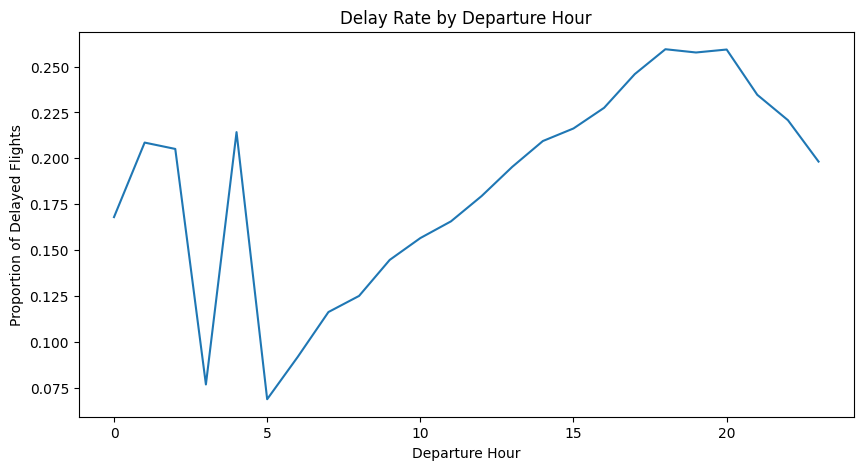

In [15]:
plt.figure(figsize=(10,5))
hourly_delay.plot()
plt.title("Delay Rate by Departure Hour")
plt.xlabel("Departure Hour")
plt.ylabel("Proportion of Delayed Flights")
plt.show()

### Departure Time Analysis Insight

Delay rates increase as the day progresses. Flights departing between 16:00 and 20:00 show the highest delay rates.

This pattern suggests a delay propagation effect, where delays accumulate throughout the day due to aircraft rotation and operational congestion.

Early morning flights tend to have lower delay rates, likely because operations start fresh with minimal accumulated disruption.

## 4. Feature Engineering

To enhance model performance and interpretability, the following engineered features were created:

- Departure Hour extracted from scheduled departure time.
- Season derived from month.
- Weekend indicator.
- Peak delay hour indicator.
- Weather impact flag.

These engineered features capture operational and seasonal effects more effectively.

In [16]:
def get_season(month):
    if month in [12,1,2]:
        return "Winter"
    elif month in [3,4,5]:
        return "Spring"
    elif month in [6,7,8]:
        return "Summer"
    else:
        return "Fall"

flights["SEASON"] = flights["MONTH"].apply(get_season)

flights[["MONTH","SEASON"]].head()

,MONTH,SEASON
0,4,Spring
1,1,Winter
2,7,Summer
3,5,Spring
4,7,Summer


In [17]:
flights["IS_WEEKEND"] = flights["DAY_OF_WEEK"].apply(lambda x: 1 if x in [6,7] else 0)

flights[["DAY_OF_WEEK","IS_WEEKEND"]].head()

,DAY_OF_WEEK,IS_WEEKEND
0,2,0
1,6,1
2,3,0
3,2,0
4,1,0


In [18]:
flights["IS_PEAK_DELAY_HOUR"] = flights["DEP_HOUR"].apply(lambda x: 1 if 16 <= x <= 20 else 0)

flights[["DEP_HOUR","IS_PEAK_DELAY_HOUR"]].head()

,DEP_HOUR,IS_PEAK_DELAY_HOUR
0,13,0
1,19,1
2,6,0
3,8,0
4,10,0


In [19]:
flights["WEATHER_DELAY"].isnull().sum()

np.int64(159897)

In [20]:
flights["WEATHER_DELAY"] = flights["WEATHER_DELAY"].fillna(0)

In [21]:
flights["WEATHER_DELAY"].isnull().sum()

np.int64(0)

In [22]:
flights["WEATHER_IMPACT"] = flights["WEATHER_DELAY"].apply(lambda x: 1 if x > 0 else 0)

flights["WEATHER_IMPACT"].value_counts()

WEATHER_IMPACT
0    194311
1      2199
Name: count, dtype: int64

In [23]:
flights.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAYED,DEP_HOUR,SEASON,IS_WEEKEND,IS_PEAK_DELAY_HOUR,WEATHER_IMPACT
0,2015,4,7,2,EV,4900,N759EV,FWA,DTW,1340,...,NaN,NaN,NaN,0.0,0,13,Spring,0,0,0
1,2015,1,24,6,AS,611,N413AS,LAS,SEA,1910,...,NaN,NaN,NaN,0.0,0,19,Winter,1,1,0
2,2015,7,8,3,WN,1483,N463WN,OAK,SEA,630,...,NaN,NaN,NaN,0.0,0,6,Summer,0,0,0
3,2015,5,26,2,WN,193,N7745A,STL,DAL,810,...,0.0,0.0,152.0,0.0,1,8,Spring,0,0,0
4,2015,7,6,1,UA,253,N213UA,IAH,HNL,1000,...,NaN,NaN,NaN,0.0,0,10,Summer,0,0,0
5,2015,9,14,1,DL,1381,N977DL,HSV,ATL,1800,...,NaN,NaN,NaN,0.0,0,18,Fall,0,1,0
6,2015,9,13,7,UA,1459,N26210,IAH,TPA,1357,...,NaN,NaN,NaN,0.0,0,13,Fall,1,0,0
7,2015,6,22,1,AS,656,N523AS,SEA,PHX,1120,...,NaN,NaN,NaN,0.0,0,11,Summer,0,0,0
8,2015,12,15,2,AA,1,N794AA,JFK,LAX,900,...,NaN,NaN,NaN,0.0,0,9,Winter,0,0,0
9,2015,10,26,1,F9,711,N210FR,14635,11292,725,...,NaN,NaN,NaN,0.0,0,7,Fall,0,0,0


In [24]:
features = [
    "DISTANCE",
    "DEP_HOUR",
    "SCHEDULED_TIME",
    "IS_WEEKEND",
    "WEATHER_IMPACT",
    "IS_PEAK_DELAY_HOUR",
    "AIRLINE",
    "SEASON"
]

X = flights[features]
y = flights["DELAYED"]

In [25]:
X = pd.get_dummies(X, drop_first=True)
# Converts categorical columns in X into numeric columns using one-hot encoding.

## 5. Model Development

A Logistic Regression model was used to predict flight delays.

Due to class imbalance in the dataset (majority of flights not delayed), a balanced class weight approach was applied to improve recall for delayed flights.

In [26]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [27]:

model = LogisticRegression(max_iter=5000, class_weight="balanced")

model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [28]:
y_pred = model.predict(X_test)


In [29]:

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6327922243142843

Confusion Matrix:
 [[20674 11288]
 [ 3144  4196]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.65      0.74     31962
           1       0.27      0.57      0.37      7340

    accuracy                           0.63     39302
   macro avg       0.57      0.61      0.55     39302
weighted avg       0.76      0.63      0.67     39302



## 6. Model Evaluation

A Logistic Regression model with class_weight="balanced" was trained to address class imbalance in the dataset.

The model achieved an overall accuracy of approximately 63%. 

While the overall accuracy decreased compared to an imbalanced model, the recall for delayed flights improved significantly (57%). 

This indicates that the model is more effective at identifying flights that are likely to be delayed, which is more important for operational planning than simply maximizing overall accuracy.

Therefore, the balanced Logistic Regression model provides a more practical solution for delay prediction.

## 7. Important Factors Influencing Delays

Model coefficients indicate the relative impact of each feature on delay probability.

Key findings:

- Weather impact is the strongest predictor of delay.
- Seasonal effects (Winter and Summer) increase delay likelihood.
- Certain airlines show higher delay probability.
- Peak departure hours increase risk of delay.

These findings align with time-based exploratory analysis results.

In [30]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
})

coefficients = coefficients.sort_values(by="Coefficient", ascending=False)

coefficients.head(10)

,Feature,Coefficient
4,WEATHER_IMPACT,6.581178
13,AIRLINE_NK,0.551061
21,SEASON_Winter,0.543308
20,SEASON_Summer,0.522378
10,AIRLINE_F9,0.398668
19,SEASON_Spring,0.348905
7,AIRLINE_B6,0.199042
5,IS_PEAK_DELAY_HOUR,0.111495
9,AIRLINE_EV,0.096725
12,AIRLINE_MQ,0.067607


## 8. Conclusion

This project successfully developed a flight delay prediction model using historical operational data.

Key insights include:

- Weather is the most significant factor affecting delays.
- Delay probability increases during peak evening hours.
- Seasonal and airline-specific patterns influence delay rates.
- Addressing class imbalance improves detection of delayed flights.

This analysis demonstrates how data-driven insights can support airline operational planning and delay mitigation strategies.

In [31]:
flights.to_csv("flight_delay_cleaned.csv", index=False)

In [32]:
# Creating  a smaller sample for GitHub upload
flights.sample(5000, random_state=42).to_csv(
    "flight_delay_sample.csv", 
    index=False
)

print("5K sample dataset exported successfully.")

5K sample dataset exported successfully.
